# Выявление определяющих закономерностей успешного продукта на примере компьютерных игр

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Необходимо выявить определяющие успешность игры закономерности.

## Чтение данных

In [1]:
# импорт необходимых для исследования библиотек
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# чтение представлено на анализ файла
df = pd.read_csv('/datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Файл прочитался корректно.

## Предобработка данных

### Приведение название колонок к стандарту применяемого языка анализа

In [3]:
# приведение название колонок к нижнему регистру
df.columns = df.columns.str.lower()

Описание данных:

- name — название игры;
- platform — платформа;
- year_of_release — год выпуска;
- genre — жанр игры;
- na_sales — продажи в Северной Америке (миллионы проданных копий);
- eu_sales — продажи в Европе (миллионы проданных копий);
- jp_sales — продажи в Японии (миллионы проданных копий);
- other_sales — продажи в других странах (миллионы проданных копий);
- critic_score — оценка критиков (максимум 100);
- user_score — оценка пользователей (максимум 10);
- rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board).

### Выявление дубликатов в данных. Анализ и обработка пропущенных значений

Проверим данные на янвные(полные) дубликаты и пропущенные значения.

In [4]:
# определение явных(полных) дубликатов
df.duplicated().sum()

0

In [5]:
# определение пропущенных значений
pd.DataFrame({'NaN_count': df.isna().sum(),
               'NaN_share':df.isna().mean()})

,NaN_count,NaN_share
name,2,0.000120
platform,0,0.000000
year_of_release,269,0.016093
genre,2,0.000120
na_sales,0,0.000000
eu_sales,0,0.000000
jp_sales,0,0.000000
other_sales,0,0.000000
critic_score,8578,0.513192
user_score,6701,0.400897


Явные (полные) дубликаты отсутвуют.

Ряд колонок имеют пропуски. Название и жанр игры имеют по два пропуска. Проверим, одни и те же это объекты?

In [6]:
# проверка на симметрию пропусков названия и жанра игры
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Действительно, игры без названия также имеют пропуске в колонке с жанром и не имеют скоров и рейтингов, кроме того выпущены в далеком 1993 году, избавимся от них без сожаления.

In [7]:
# удаление строк с пропусками в названии игр и жанров
df = df.drop(df[df['name'].isna()].index)

Колонка с годами выпуска игр имеет 269 пропущеных значения. Обратимся к столбцу с названием игр. Некоторые игры содержат числовые наименования, очень похожие на год... Выделим "года" игр из названия игр и заменим ими пропуски в годах релиза.

In [8]:
# выделение из название игр числовых значений
df['year_from_name'] = df['name'].str.extract('([0-9]{4})')

# замена пропусков на значения годов из названия игр
df.loc[df['year_of_release'].isna(), 'year_of_release'] = df['year_from_name']

# удаление временной (технической) колонки
df = df.drop('year_from_name', axis=1)

In [9]:
# определения пропущенных значений
pd.DataFrame({'NaN_count': df.isna().sum(),
               'NaN_share':df.isna().mean()})

,NaN_count,NaN_share
name,0,0.000000
platform,0,0.000000
year_of_release,252,0.015078
genre,0,0.000000
na_sales,0,0.000000
eu_sales,0,0.000000
jp_sales,0,0.000000
other_sales,0,0.000000
critic_score,8576,0.513133
user_score,6699,0.400826


Количество пропусков в колонке с годами выхда игр снизилось до 252.

Колонки со скорами и рейтингом игр заполнять не стоит, чтобы не исказить результат исследования. 

Опора при определнии успешности продукта будет на сведения об объемах продажах.

Объемы реализации продукта рассмотрим в разрезе жанров, платформах, днамики по годам, что и определит паттерны высоких продаж. Скоры и рейтинги будут дополнительным (косвенным) свидетельством успешности игры.

Далее преобразуем типы данных.

### Преобразование типов данных

In [10]:
# изучение типов данных
df.dtypes

name                object
platform            object
year_of_release     object
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

Стоит сменить тип данных года выпуска с непрерывного (числа с плавающей точкой) на дискретный, а также пользовательский скор с объекта (строчный тип) на непрерывный.

Дополнительно отметим, что колонка с оценкой игры игроками содержит аббревиатуру tbd, что определяется, как to be determined / to be decided. То есть оценка еще игроками не выставлена, очевидно, пользователи еще не достаточно изучили продукт для оценки, либо на момент формирования датасета оценка игры пользователями находяиться в расчетной стадии. Заменит акроним на пропуски (нет данных). 

Колонка с рейтингами имеет пропущенные значения. Возмжно, игры без рейтинга не представляют интереса для ESRB, либо по иной причине не имеют рейтинга. Заменим пропущенные значения на запись об отсутвие рейтинга.

In [11]:
# замена пропущеных значений
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['rating'] = df['rating'].replace(np.nan, 'not determined')

# приведение типов данных к соответсвующим
df['year_of_release'] = df['year_of_release'].fillna(0).astype(int).replace(0, np.nan).astype('Int64')
df['user_score'] = df['user_score'].astype(float)

### Расчет объема мировых продаж

In [12]:
# рассчет суммарных продаж по всм регионам
df['sales_total'] = (df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']]).sum(axis=1)

### Выводы по результатам предобработки данных

In [13]:
# общая информация о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16461 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           16713 non-null  object 
 11  sales_total      16713 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 2.2+ MB


Подведем итог. Представленные на исследование данные содержат 16713 записей (наблюдений) об играх с собранными 12 признаками наблюдений.

Даные приведены к соответсвующим типам. Пропущенные значения предобработаны.

## Исследовательский анализ данных

### Динамика выпуска игр по годам

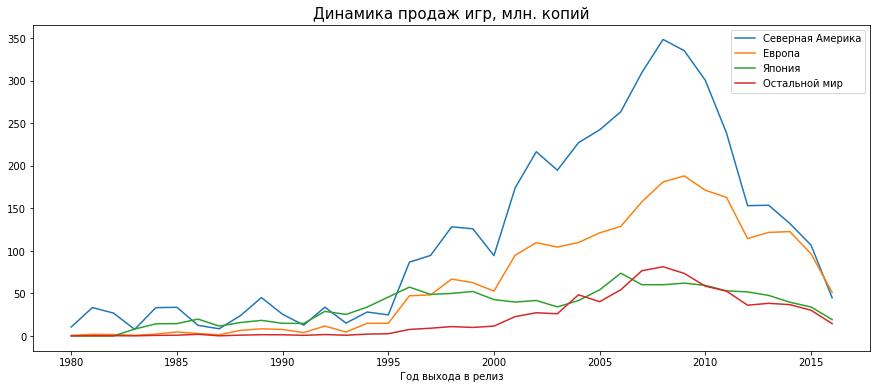

In [14]:
# расчет объема продаж игр по годам
sales_per_years = df.groupby('year_of_release').agg(na_sales_total = ('na_sales', 'sum'),
                                 eu_sales_total = ('eu_sales', 'sum'),
                                 jp_sales_total = ('jp_sales', 'sum'),
                                 other_sales_total = ('other_sales', 'sum'))

# визуализация расчетов
plt.figure(figsize=(15, 6))
plt.plot(sales_per_years)
plt.title('Динамика продаж игр, млн. копий', fontsize=15)
plt.xlabel('Год выхода в релиз')
plt.legend(['Северная Америка', 'Европа', 'Япония', 'Остальной мир'])
plt.show()

В период 80-х и начала 90-х годов, активных релизов игр не происходило. Продажи игр начинают активно расти, начиная с 1995 года. Лидером роста продаж выступает Северо-Американский регион, Япония конкурирует с прочими мировыми регионами, проигрывая 2007-2009 года. Промежуточное положение занимают объемы продаж в Европе. Пиковым годом продаж стоит признать сезон 2008-2009 годов, после которого настует спад.

Ограничим горизонт анализа периодом 1996 года. Периодом начала бурного роста.

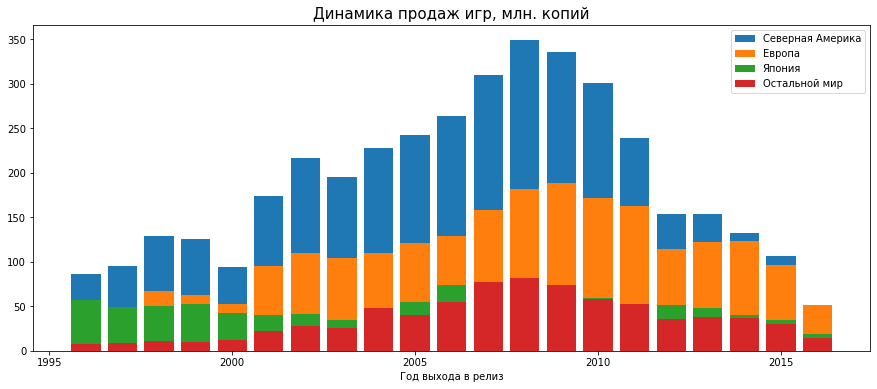

,year_of_release,na_sales_total,eu_sales_total,jp_sales_total,other_sales_total,world_sales_total
0,1996,86.760000,47.260000,57.440000,7.690000,199.150000
1,1997,94.750000,48.320000,48.870000,9.130000,201.070000
2,1998,128.360000,66.900000,50.040000,11.010000,256.310000
3,1999,126.060000,62.670000,52.340000,10.040000,251.110000
4,2000,94.500000,52.770000,42.770000,11.620000,201.660000
5,2001,173.980000,94.890000,39.860000,22.730000,331.460000
6,2002,216.720000,109.770000,41.760000,27.300000,395.550000
7,2003,194.950000,104.520000,34.200000,26.150000,359.820000
8,2004,227.360000,109.900000,41.700000,48.460000,427.420000
9,2005,242.420000,121.260000,54.270000,40.340000,458.290000


In [15]:
# расчет объема продаж, начиная с 1996 года
sales_per_years_from_1995 = (
    df[df['year_of_release'] > 1995]
    .groupby('year_of_release')
    .agg(na_sales_total = ('na_sales', 'sum'),
         eu_sales_total = ('eu_sales', 'sum'),
         jp_sales_total = ('jp_sales', 'sum'),
         other_sales_total = ('other_sales', 'sum'),
        world_sales_total = ('sales_total', 'sum'))
    .reset_index()
)

# визуализация расчетов
plt.figure(figsize=(15, 6))
plt.bar(sales_per_years_from_1995['year_of_release'], sales_per_years_from_1995['na_sales_total'])
plt.bar(sales_per_years_from_1995['year_of_release'], sales_per_years_from_1995['eu_sales_total'])
plt.bar(sales_per_years_from_1995['year_of_release'], sales_per_years_from_1995['jp_sales_total'])
plt.bar(sales_per_years_from_1995['year_of_release'], sales_per_years_from_1995['other_sales_total'])
plt.title('Динамика продаж игр, млн. копий', fontsize=15)
plt.xlabel('Год выхода в релиз')
plt.legend(['Северная Америка', 'Европа', 'Япония', 'Остальной мир'])
plt.show()

# расчетная таблица
(
    sales_per_years_from_1995
    .style
    .background_gradient(cmap='Blues', subset=['na_sales_total',
                                               'eu_sales_total',
                                               'jp_sales_total',
                                               'other_sales_total',
                                               'world_sales_total'])
)

Начина с 1996 года в игровой индустрии наметился рост. Суммарные продажи стартовали с отметки в 199 млн. копий в том числе 86 млн. - Северная Америка, 47 млн. - Европа, 57 млн. - Япония и  7 млн. - прочие регионы. И уже к 2004 году инлустрия удвоила продажи - 427 млн., в том числе 227 млн. -  Северная Америка, 109 млн. - Европа, 41 млн. - Япония, 48 млн. - прочие регионы. 

Лучшим годом за анализируемый период беспорно явлется 2008 - 671 млн. копий игр реализовано во всем мире. Этот же год топый для северо-американского региона - 348 млн. игр реализовано в этом году и остального мира - 81 млн. В Европе таким годом явлется 2009 - 188 млн, в Японии - 2006 год - 73 млн.

Начиная с периода конца десятых годов двадцать первого столетия в игровой индустрии наметился спад - продажи снижаются по всем регионам и концу 2016 года достигают локального минимума в 129 млн., что ниже отправной точки анализа - 1996 года в 199 млн. В Северной Америке продано 45 млн., в Европе 51 млн., в Японии 19 млн., на остальной мир пришлом 14 млн.

### Продажи игр в разрезе платформ

In [16]:
# расчет объема продаж по регионам в разрезе платформ
(
    df[df['year_of_release'] > 1995]
    .groupby('platform')
    .agg(na_sales_total = ('na_sales', 'sum'),
         eu_sales_total = ('eu_sales', 'sum'),
         jp_sales_total = ('jp_sales', 'sum'),
         other_sales_total = ('other_sales', 'sum'),
         world_sales_total = ('sales_total', 'sum'))
    .style
    .background_gradient(cmap='Blues', subset=['na_sales_total',
                                               'eu_sales_total',
                                               'jp_sales_total',
                                               'other_sales_total',
                                               'world_sales_total'])
)

,na_sales_total,eu_sales_total,jp_sales_total,other_sales_total,world_sales_total
platform,,,,,
3DS,82.650000,61.270000,100.620000,13.270000,257.810000
DC,5.430000,1.690000,8.560000,0.270000,15.950000
DS,380.320000,188.410000,175.000000,59.040000,802.770000
GB,49.520000,31.370000,50.480000,4.930000,136.300000
GBA,184.120000,74.590000,46.560000,7.610000,312.880000
GC,132.170000,38.380000,21.340000,5.140000,197.030000
N64,138.910000,41.030000,33.760000,4.310000,218.010000
NG,0.000000,0.000000,0.100000,0.000000,0.100000
PC,84.860000,129.790000,0.170000,21.100000,235.920000


Итак, наиболее крупные продажи игр за анализируемый актуальный период (с 1996 года включительно) имели место на платформах PS. Так, PS2 - 1247 млн. копий, PS3- 931 млн., PS - 685 млн. Платформы Wii и X360 - к 2016 году суммарно реализовали 891 млн. и 961 млн. копий игр соответсвенно. Платформа DS - 802 млн.

Отметим, интерес пользователь к платформе PS имеет общемировой, так, например, по платформе PS2 - продажи распределены практически равномерно по всем регионам: 580 млн. - Севрная Америка, 337 млн. - Европа, 137 млн. - Япония и 192 млн. - прочие регионы. В то время, как, например, к платформам Wii и X360 - интерес смещен к пользоватлеям из Северной Америке, 486 млн. и 595 млн. соответсвенно, а к платформе DS тяготеют пользователи из Японии - 175 млн.

Далее расмотрим динамику продаж игр по отмеченным популяным платформам по годам в разрезе регионов.

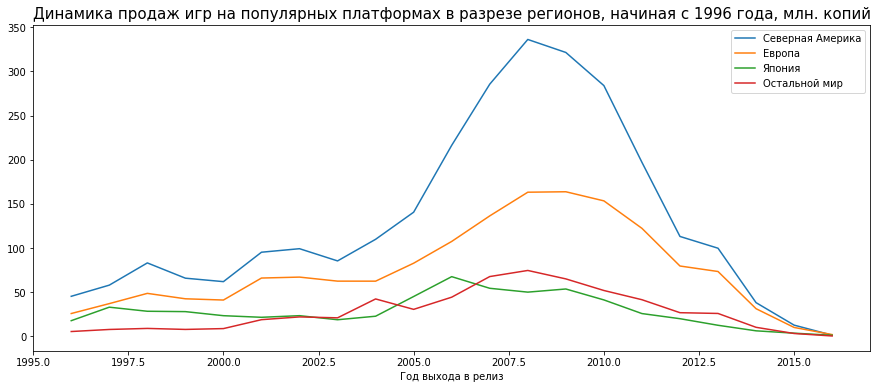

,na_sales_total,eu_sales_total,jp_sales_total,other_sales_total
year_of_release,,,,
1996,45.420000,25.920000,17.820000,5.540000
1997,58.060000,37.140000,33.100000,7.870000
1998,83.220000,48.740000,28.480000,9.050000
1999,65.940000,42.600000,28.070000,7.920000
2000,62.020000,41.190000,23.470000,8.860000
2001,95.330000,66.090000,21.650000,18.950000
2002,99.320000,67.160000,23.490000,22.080000
2003,85.490000,62.590000,18.880000,21.040000
2004,109.960000,62.560000,22.870000,42.430000


In [17]:
# расчет динамики продаж по регионам среди популярных платформ начиная с 1996 года
sales_per_year_per_region = (
    df.loc[(df['platform'].isin(['DS', 'PS', 'PS2', 'PS3', 'Wii', 'X360'])) &
          (df['year_of_release'] > 1995)]
    .groupby('year_of_release')
    .agg(na_sales_total = ('na_sales', 'sum'),
         eu_sales_total = ('eu_sales', 'sum'),
         jp_sales_total = ('jp_sales', 'sum'),
         other_sales_total = ('other_sales', 'sum'))
)

# визуализация расчетов
plt.figure(figsize=(15, 6))
plt.plot(sales_per_year_per_region)
plt.title('Динамика продаж игр на популярных платформах в разрезе регионов, начиная с 1996 года, млн. копий', 
          fontsize=15)
plt.xlabel('Год выхода в релиз')
plt.legend(['Северная Америка', 'Европа', 'Япония', 'Остальной мир'])
plt.show()

# расчтеная таблица
(
    sales_per_year_per_region
    .style
    .background_gradient(cmap='Blues', subset=['na_sales_total',
                                               'eu_sales_total',
                                               'jp_sales_total',
                                               'other_sales_total'])
)

Таким образом, динамика продажи игр на выделенных популярных платформах повторяет амплитуду продаж по всем платформам. Так, рост мировых продаж среди выделенных популярных платформ начинается в 1996 года с 5,5 млн. копий, достигает пика в 2008 года - 74 млн. и снижается, приближаясь к нулю в 2016 году.

Таким образом, выделенные поппулярные платформы, на рассматриваем анализируемом периоде, являются образующими элементами прода всей игровой индустрии вплодь до 2016 года.

Далее расмотрим динамику продаж игр по отмеченным популяным платформам по годам (начиная с 1996 года) в разрезе платформ, - опредлим за какой характерный срок появляются новые и исчезают старые платформы.

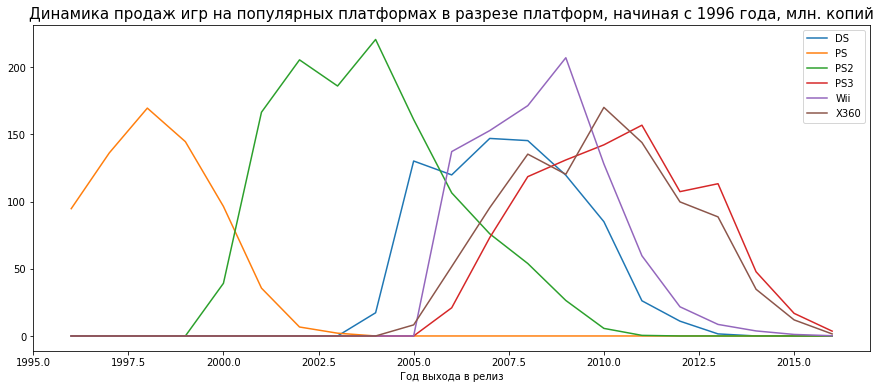

platform,DS,PS,PS2,PS3,Wii,X360
year_of_release,,,,,,
1996,0.000000,94.700000,0.000000,0.000000,0.000000,0.000000
1997,0.000000,136.170000,0.000000,0.000000,0.000000,0.000000
1998,0.000000,169.490000,0.000000,0.000000,0.000000,0.000000
1999,0.000000,144.530000,0.000000,0.000000,0.000000,0.000000
2000,0.000000,96.370000,39.170000,0.000000,0.000000,0.000000
2001,0.000000,35.590000,166.430000,0.000000,0.000000,0.000000
2002,0.000000,6.670000,205.380000,0.000000,0.000000,0.000000
2003,0.000000,2.070000,185.930000,0.000000,0.000000,0.000000
2004,17.270000,0.000000,220.550000,0.000000,0.000000,0.000000


In [18]:
# расчет динамики суммарных мировых продаж по популярным платформам, начиная с 1996 года
sales_per_year_per_platform = (
    df.loc[(df['platform'].isin(['DS', 'PS', 'PS2', 'PS3', 'Wii', 'X360'])) &
          (df['year_of_release'] > 1995)]
    .pivot_table(index='year_of_release', columns='platform', values='sales_total', aggfunc='sum')
    .fillna(0)
)

# визуализация расчетов
plt.figure(figsize=(15, 6))
plt.plot(sales_per_year_per_platform)
plt.title('Динамика продаж игр на популярных платформах в разрезе платформ, начиная с 1996 года, млн. копий', fontsize=15)
plt.xlabel('Год выхода в релиз')
plt.legend(['DS', 'PS', 'PS2', 'PS3', 'Wii', 'X360'])
plt.show()

# расчетная таблица
(
    sales_per_year_per_platform
    .style
    .background_gradient(cmap='Blues', subset=['DS', 'PS', 'PS2', 'PS3', 'Wii', 'X360'])
)

Таким образом, средний срок "жизни" игровой платформы - семь лет.

Так, платформа DS вошла на ировой рынок в 2004 года с объемом продаж в 17 млн. копий, достигла пика  продаж в 146-145 млн. на рубеже 2007-2008 годов, а после 2010 года объем продаж игр стал снижаться, прекратив полное существание к 2014 году.

Аналогичное поведение демонсриуют и прочие платформы.

Дополнительно отметим, что именно выделенные популярные платформы достиглы пиков продаж к лучшему за анализируемой период году игровой индустрии - 2008: Wii, DS, X360 и PS3 реализовали в этот период 145 млн., 118 млн., 171 млн., 135 млн. копий игр соответсвенно.

Итак, для стремительно развивающейся игровой индустрии период больше 3-4 лет — очень много. Внутри выбранного периода резкого роста игровой индустрии, начиная с 1996 года, произошли резкие изменения, например, произошла замена одного поколения консолей следующим (PS -> PS2 -> PS3 -> PS4). Некоторые платформы совсем исчезли.

Для целей прогнозирования продаж на следующий год даже в традиционных бизнесах редко берут данные более чем за 2-3 года. А в такой динамично меняющейся индустрии, как компьютерные игры и вовсе не стоит брать слишком большой временной интервал.

Таким образом, для дальнейшего анализа целесообразно использовать данные начиная с 2014 года по выделенным популярным платформам - PS3, Wii, X360.

In [19]:
# актульные данные для дальнейшего анализа
actual_data = (
    df.loc[
        (df['year_of_release'] > 2013) & 
        (df['platform'].isin(['PS3', 'Wii', 'X360']))
    ]
)

Изучим на сколько в среднем хорошо продаются игры на выделенных для прогноза на 2017 год данных.

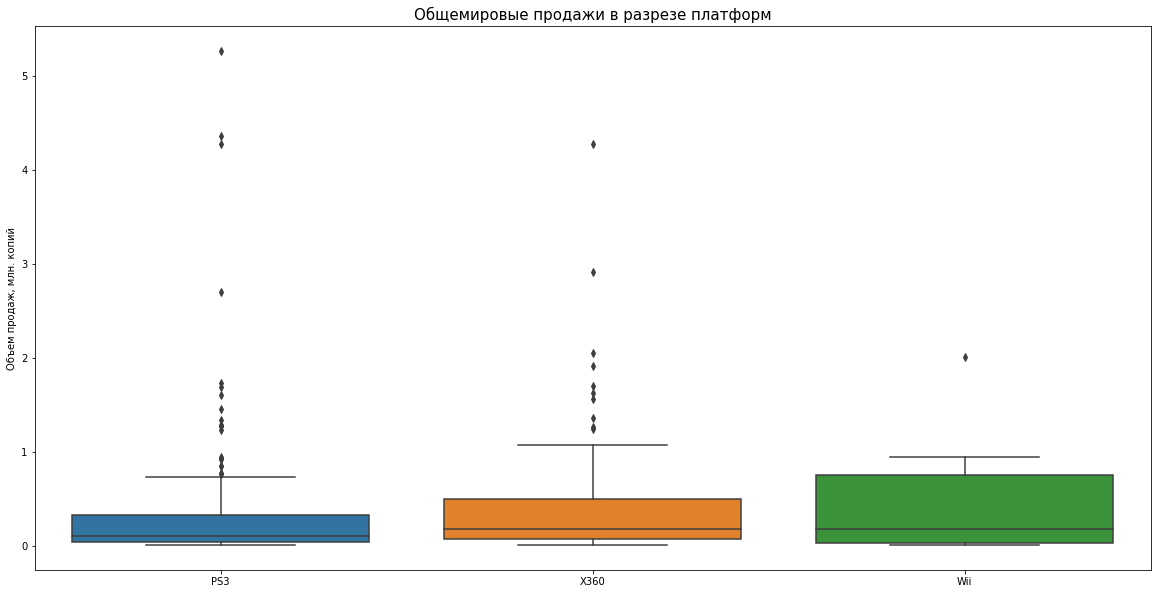

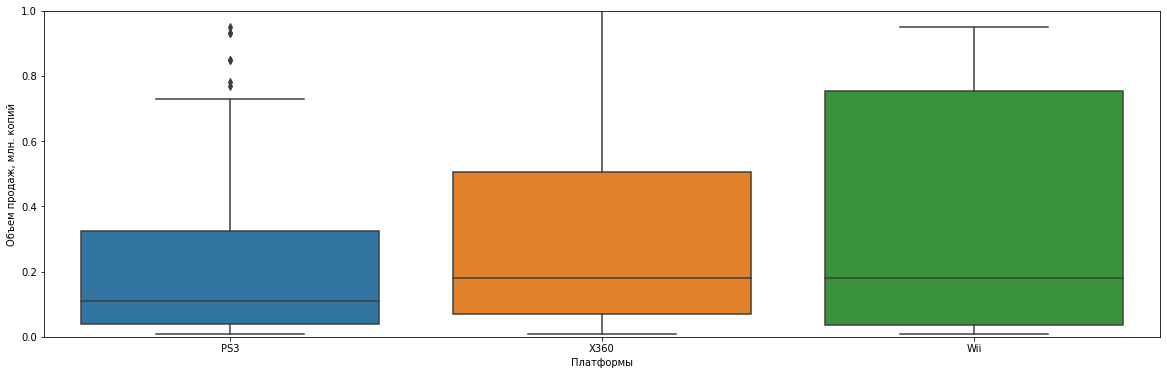

,platform_sales_total
count,341.000000
mean,0.356217
std,0.632537
min,0.010000
25%,0.040000
50%,0.120000
75%,0.410000
max,5.270000


In [20]:
# визуализация размаха общемировых продаж в разрезе платформ
plt.figure(figsize=(20, 10))
sns.boxplot(data=actual_data, x='platform', y='sales_total')
plt.title('Общемировые продажи в разрезе платформ', fontsize=15)
plt.xlabel('')
plt.ylabel('Объем продаж, млн. копий')
plt.show()

# визуализация размаха общемировых продаж в разрезе платформ (мастшабированная)
plt.figure(figsize=(20, 6))
sns.boxplot(data=actual_data, x='platform', y='sales_total')
plt.ylim(0, 1)
plt.xlabel('Платформы')
plt.ylabel('Объем продаж, млн. копий')
plt.show()

# саммари мировых продаж по всем выделенным популярным платформам
actual_data[['platform', 'sales_total']].describe().rename({'sales_total': 'platform_sales_total'}, axis=1)

Таким образом, исходя из 341 наблюдения следует отметить, что среднее значения объема продаж игр на выделенных данных достигает 35 тыс. копий игр, при медиане в 12 тыс. и стандартном отклонении в 6 тыс. игр.

Кроме того достигнут максимум в 5,2 млн. копий игр для платформы PS3.

Исходя из медианного показателя диаграммы размаха продаж видеоигр по платформам лучше игры продаются на платформах X360 и Wii.

Далее рассмотрим влияние эксперных оценок на объемы продаж.

### Влияние оценок критиков на объемы продаж на примере платформы PS3

,critic_score,na_sales,eu_sales,jp_sales,other_sales,sales_total
critic_score,1.000000,0.468665,0.373391,0.421033,0.509179,0.494554
na_sales,0.468665,1.000000,0.891972,0.193446,0.897733,0.968336
eu_sales,0.373391,0.891972,1.000000,0.148664,0.918175,0.950774
jp_sales,0.421033,0.193446,0.148664,1.000000,0.276668,0.328178
other_sales,0.509179,0.897733,0.918175,0.276668,1.000000,0.950619
sales_total,0.494554,0.968336,0.950774,0.328178,0.950619,1.000000


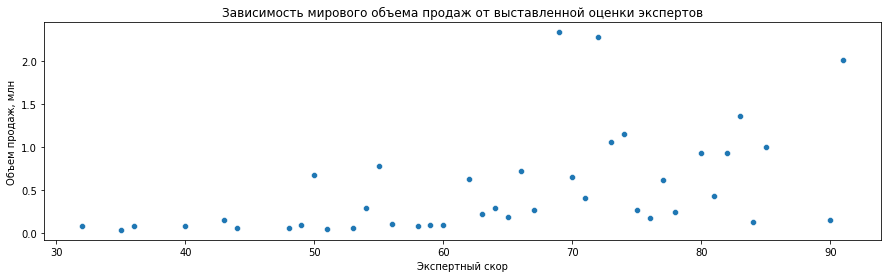

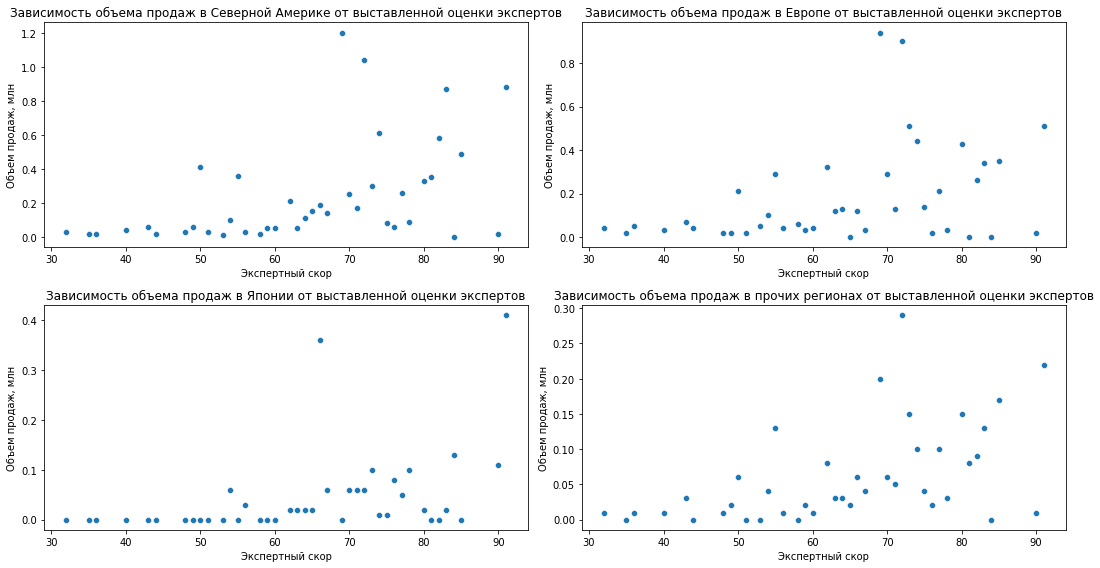

In [21]:
# расчет объемов продаж в зависимости от оценки экспертов
ps3_sales_per_critic_score = (
    actual_data
    .groupby('critic_score')
    [['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'sales_total']]
    .sum()
    .reset_index()
)

# расчет корреляции объемов продаж от оценки экспертов
display(ps3_sales_per_critic_score.corr())

# визуализация расчетов
plt.figure(figsize=(15, 4))
sns.scatterplot(data=ps3_sales_per_critic_score, x='critic_score', y='sales_total')
plt.title('Зависимость мирового объема продаж от выставленной оценки экспертов')
plt.ylabel('Объем продаж, млн')
plt.xlabel('Экспертный скор')


plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
sns.scatterplot(data=ps3_sales_per_critic_score, x='critic_score', y='na_sales')
plt.title('Зависимость объема продаж в Северной Америке от выставленной оценки экспертов')
plt.ylabel('Объем продаж, млн')
plt.xlabel('Экспертный скор')

plt.subplot(2, 2, 2)
sns.scatterplot(data=ps3_sales_per_critic_score, x='critic_score', y='eu_sales')
plt.title('Зависимость объема продаж в Европе от выставленной оценки экспертов')
plt.ylabel('Объем продаж, млн')
plt.xlabel('Экспертный скор')

plt.subplot(2, 2, 3)
sns.scatterplot(data=ps3_sales_per_critic_score, x='critic_score', y='jp_sales')
plt.title('Зависимость объема продаж в Японии от выставленной оценки экспертов')
plt.ylabel('Объем продаж, млн')
plt.xlabel('Экспертный скор')

plt.subplot(2, 2, 4)
sns.scatterplot(data=ps3_sales_per_critic_score, x='critic_score', y='other_sales')
plt.title('Зависимость объема продаж в прочих регионах от выставленной оценки экспертов')
plt.ylabel('Объем продаж, млн')
plt.xlabel('Экспертный скор')

plt.tight_layout()
plt.show()

Во всех рассмотренных регионах по платформе PS3 наблюдается небольшая линейная зависимость объема продаж видеоигр от оценки критиков. Так, сильнее всего связь наблюдается в продаж в прочих регионах и общих мировых продажа, в районе 0,5, слабее в Европе - 0,37.

Кроме того, пик объема продаж приходиться по на экспертный скор равный около 70-ти баллов, далее при увеличения оценочного балла, объемы продаж начинаются снижатся. Данное наблюдение также объясняется спецификой конкретной игры на рассматриваемой платформе и различий предпочтней критиков и массового потребителя.

Далее изучим зависимости оценок пользователей и объема продаж.

### Влияние оценок критиков на объемы продаж на примере платформы PS3

,user_score,na_sales,eu_sales,jp_sales,other_sales,sales_total
user_score,1.000000,0.051121,0.031379,0.411097,0.036427,0.087045
na_sales,0.051121,1.000000,0.601069,0.055569,0.784542,0.870239
eu_sales,0.031379,0.601069,1.000000,0.161810,0.895215,0.904948
jp_sales,0.411097,0.055569,0.161810,1.000000,0.198061,0.235935
other_sales,0.036427,0.784542,0.895215,0.198061,1.000000,0.956984
sales_total,0.087045,0.870239,0.904948,0.235935,0.956984,1.000000


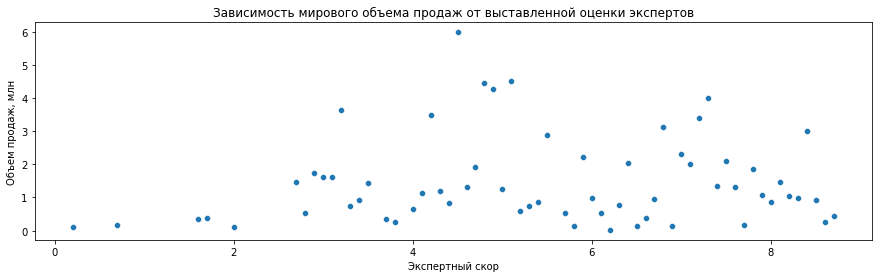

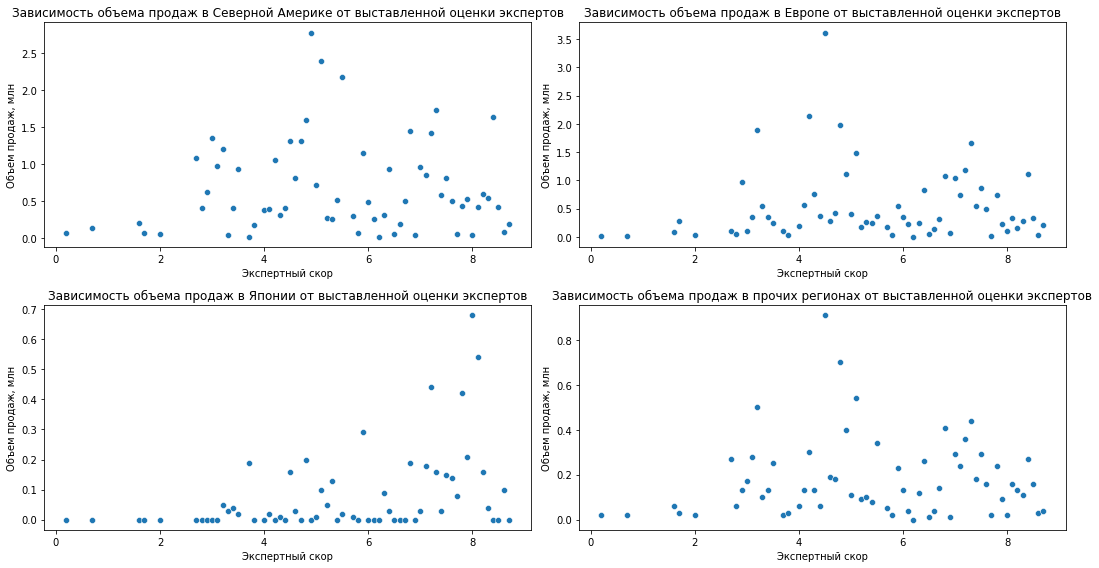

In [22]:
# расчет объемов продаж в зависимости от оценки экспертов
ps3_sales_per_user_score = (
    actual_data
    .groupby('user_score')
    [['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'sales_total']]
    .sum()
    .reset_index()
)

# расчет корреляции объемов продаж от оценки экспертов
display(ps3_sales_per_user_score.corr())

# визуализация расчетов
plt.figure(figsize=(15, 4))
sns.scatterplot(data=ps3_sales_per_user_score, x='user_score', y='sales_total')
plt.title('Зависимость мирового объема продаж от выставленной оценки экспертов')
plt.ylabel('Объем продаж, млн')
plt.xlabel('Экспертный скор')


plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
sns.scatterplot(data=ps3_sales_per_user_score, x='user_score', y='na_sales')
plt.title('Зависимость объема продаж в Северной Америке от выставленной оценки экспертов')
plt.ylabel('Объем продаж, млн')
plt.xlabel('Экспертный скор')

plt.subplot(2, 2, 2)
sns.scatterplot(data=ps3_sales_per_user_score, x='user_score', y='eu_sales')
plt.title('Зависимость объема продаж в Европе от выставленной оценки экспертов')
plt.ylabel('Объем продаж, млн')
plt.xlabel('Экспертный скор')

plt.subplot(2, 2, 3)
sns.scatterplot(data=ps3_sales_per_user_score, x='user_score', y='jp_sales')
plt.title('Зависимость объема продаж в Японии от выставленной оценки экспертов')
plt.ylabel('Объем продаж, млн')
plt.xlabel('Экспертный скор')

plt.subplot(2, 2, 4)
sns.scatterplot(data=ps3_sales_per_user_score, x='user_score', y='other_sales')
plt.title('Зависимость объема продаж в прочих регионах от выставленной оценки экспертов')
plt.ylabel('Объем продаж, млн')
plt.xlabel('Экспертный скор')

plt.tight_layout()
plt.show()

Наличие линейной зависимости объема продаж видеоигр на рассматриваемой платформе от предпочтений польователей практически отсутвует, за исключением, возможно Японии - 0,41, при этом также наблюдается пиковая область объема продаж при оценке пользователей равной 5-ти.

Проверим выдеражат ли критику прочими популярными платформами полученные выводы. 

### Проверка выводов о влияние оценок критиков и пользоватлей на объемы мировых продаж игр по всем выделенным популярным платформам

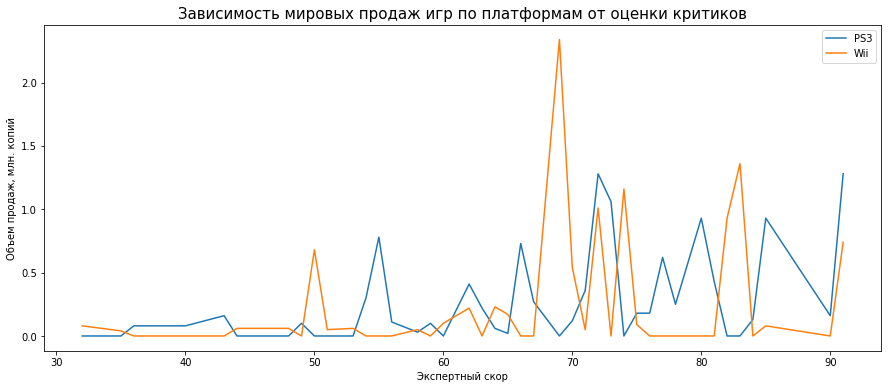

In [23]:
# расчета объема мировых продаж игр по платформам в зависмости от оценок экспертов
sales_total_per_platform_per_critic_score = (
    actual_data
    .pivot_table(
        index='critic_score', 
        columns='platform', 
        values='sales_total', 
        aggfunc='sum'
    )
    .fillna(0)
)

# визуализация расчетов
plt.figure(figsize=(15, 6))
plt.plot(sales_total_per_platform_per_critic_score)
plt.title('Зависимость мировых продаж игр по платформам от оценки критиков', fontsize=15)
plt.xlabel('Экспертный скор')
plt.ylabel('Объем продаж, млн. копий')
plt.legend(['PS3', 'Wii', 'X360'])
plt.show()

Действительно на прочих выделенных популярных платформах также выделяется небольшая линейная зависимость объема продаж от оценок крититиков, особенно на рубеже 65-85 скор-баллов.

Кроме того, вывод о пике мировых продаж при оценке критиков в районе 70-ти баллов нашел свое подтверждение на всех платформах.

Платформа Х360 не получила на момент 2016 года оценок критиков.

Проведем аналогичныые расчеты для оценок пользоватлей.

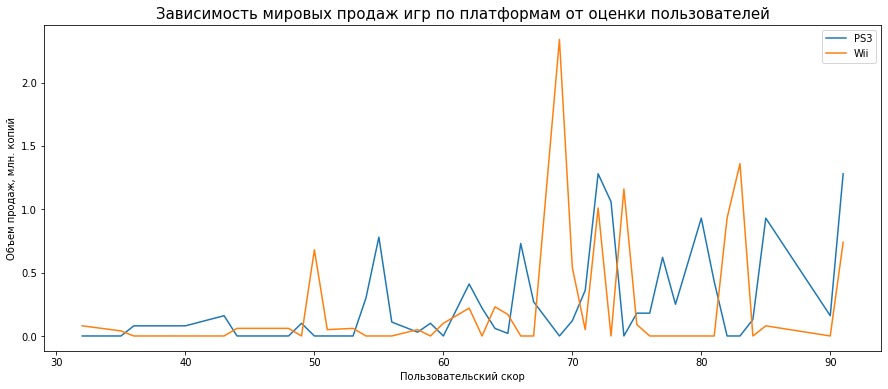

In [24]:
# расчета объема мировых продаж игр по платформам в зависмости от оценок экспертов
sales_total_per_platform_per_user_score = (
    actual_data
    .pivot_table(
        index='user_score', 
        columns='platform', 
        values='sales_total', 
        aggfunc='sum'
    )
    .fillna(0)
)

# визуализация расчетов
plt.figure(figsize=(15, 6))
plt.plot(sales_total_per_platform_per_critic_score)
plt.title('Зависимость мировых продаж игр по платформам от оценки пользователей', fontsize=15)
plt.xlabel('Пользовательский скор')
plt.ylabel('Объем продаж, млн. копий')
plt.legend(['PS3', 'Wii', 'X360'])
plt.show()

Аналогичная зависимость имеет место и оценками пользователей.

### Влияние жанра игры на объемы продаж по выделенным актуальным данным

In [25]:
# расчет объема продаж игр в зависимости от жанра
(
    actual_data
    .groupby('genre')
    .agg(game_cnt = ('name', 'count'),
         na_sales_median_score = ('na_sales', 'median'),
         eu_sales_median_score = ('eu_sales', 'median'),
         jp_sales_median_score = ('jp_sales', 'median'),
         other_sales_median_score = ('other_sales', 'median'),
         world_sales_median_score = ('sales_total', 'median'))
    .fillna(0)
    .style
    .background_gradient(cmap='Blues', 
                         subset=['na_sales_median_score',
                                 'eu_sales_median_score',
                                 'jp_sales_median_score',
                                 'other_sales_median_score',
                                 'world_sales_median_score'])
)

,game_cnt,na_sales_median_score,eu_sales_median_score,jp_sales_median_score,other_sales_median_score,world_sales_median_score
genre,,,,,,
Action,118,0.030000,0.030000,0.000000,0.010000,0.110000
Adventure,33,0.020000,0.020000,0.000000,0.000000,0.050000
Fighting,22,0.050000,0.010000,0.030000,0.010000,0.115000
Misc,22,0.060000,0.040000,0.000000,0.010000,0.155000
Platform,5,0.040000,0.050000,0.000000,0.010000,0.100000
Puzzle,1,0.000000,0.000000,0.040000,0.000000,0.040000
Racing,16,0.045000,0.030000,0.000000,0.015000,0.100000
Role-Playing,34,0.025000,0.010000,0.030000,0.010000,0.110000
Shooter,29,0.180000,0.170000,0.000000,0.060000,0.410000


Для оценки влияния жанра на объемы продаж следует испольовать медиану продаж, а не общий объем продаж или средний показатель, по следующим соображениям. Больше всего игр для анализуруемых выделенных актуальных данных реализовано в сегменте экшн - 118, в то время как, например, шутеров реализовано 29 игры. Однако, медианный показатель экшн-жанра составляет, например для Северной Америке, 30 тыс. копий, а шутеров - 180 тыс. копий. Таким образом, несмотря на значительный объем выпуска игр жанра экшн продажи слабые - то есть не пользуются популярностью, в то время как ситуация по шутерам противоположная.

Среднее значение не целесообразно использовать по причине возмодного смещения показателя продаж из-за выхода нескольких успешных игр и провала большинства.

Медиана же продемонсрует истинное положение дел в жанрах, какие жанры, действиетльно хорошо потребляются, какие плохо.

Так, как было отмечено выше лидером среди жанров является шутеры с медианой продаж 180 тыс. копий в Северной Америке, 170 тыс. копий в Европе, 6 тыс. в прочих регионах. В Японии шутеры популярнсть не снискали.

В свою очередь в Японии высокий медианный показатель у Стратегий - 6 тыс. копий, а также в жанре пазлов - 4 тыс., несмотря на то, что в осталных регионах эти жанры практически не реализуются.

### Выводы по результатам исследовательского анализа данных

В ходе исследовательского анализа данные изучены в динамике по годам, в разрезе платформ и жанров, регионов продаж и оценок игр экспертами и пользователями. Проведенным анализом установлено следующее:

1. Рост рынка видеоигр произошел в 1996 году с пиком в 2008 году и плавным спадом к 2016 году.
2. Лидером среди рынков сбыта за весь анализируемый период является Севеная Америка, аутсайдером - Япония.
3. Максимальные объемы продаж игр омечены на следующих платформах - DS, PS, PS2, PS3, Wii, X360, при этом платформа DS характерна для Японии, прочие выделенные платформы популярны во всех представленных регионах.
4. Исходя из объема реализации игр, выделены актуальные данные для дальнейшего анализа - горизонт анализа - 2014 год, игровые платформы: PS3, Wii, X360.
5. На примере платформы PS3 установлена прямая линейная зависимость объема продаж игр от оценок, как экспертов, так и игроков, при этом пик продаж игр наблюдается при скоре близком к 70-ти для критиков и оценке в  районе 6 для игроков. Вывод подтвержден на прочих платформах.
6. Жанр прямо влияет на объем продаж, так шутеры лучше всего продаются во всех регионах, а стратегии и пазлы лучше только в Японии.

Таким образом, по релультатам исследовательского анализа данных автором выделены следующие критерии успешности игры:

- регион распрастранения - Северная Америка,
- платформа - семейста PS3,
- жанр - Shooter,
- оценка в районе 70 от критиков и в районе 6 от игроков.

Далее изучим потребителей.

## Портрет пользователя

### Северная Америка
#### Игровая платформа

In [26]:
# опредеение функции, принимающий в качестве агрумента df, признак и регион для аналитического среза
# и возвращающей агрегированные расчеты топ-5 объема продаж и сопутсвующие сведения
def sales_per_feature_per_region(df, feature, region_sales):
    result = (df
              .groupby(feature)
              .agg(game_cnt = ('name', 'count'),
                   region_sales_total = (region_sales, 'sum'),
                   world_sales_total = ('sales_total', 'sum'),
                   critic_score_avg = ('critic_score', 'mean'),
                   user_score_avg = ('user_score', 'mean'))
              .assign(world_sales_share = lambda x: x['region_sales_total'] / x['world_sales_total'])
              .sort_values('region_sales_total', ascending=False)
              .head())
    return result

# расчет объемов продаж в разрезе платформ для Северной Америки
sales_per_feature_per_region(actual_data, 'platform', 'na_sales')                        

,game_cnt,region_sales_total,world_sales_total,critic_score_avg,user_score_avg,world_sales_share
platform,,,,,,
X360,111,28.30,48.22,63.730769,5.771084,0.586893
PS3,219,22.05,68.18,66.555556,6.014286,0.323409
Wii,11,2.08,5.07,NaN,6.350000,0.410256


Итак, лидером по объемам продаж в Северной Америке является платформа X360 - 28 млн. копий (58% от мировых продаж на этой платформе). Для платформы выпущено 111 игр со средней оценкой экспертов в 63 баллов и средней оценкой пользователей в 5,8 балла.

Аудсайдером является платформа  Wii  - 2 млн. копий (41% мировых продаж для этой платформы). При этом для этой платформы выпущено 11 игры со средней оценкой от игроков в 6,3 балла; критики платформу не оценили в виду новизны последней по состоянию на 2016 год.

#### Жанр игры

In [27]:
# расчет объемов продаж в разрезе жанров для Северной Америки
sales_per_feature_per_region(actual_data, 'genre', 'na_sales')                        

,game_cnt,region_sales_total,world_sales_total,critic_score_avg,user_score_avg,world_sales_share
genre,,,,,,
Sports,56,14.17,31.43,67.666667,4.363415,0.450843
Shooter,29,12.73,25.83,63.500000,6.238462,0.492838
Action,118,12.37,31.62,61.733333,6.442308,0.391208
Misc,22,4.79,11.10,78.000000,6.655556,0.431532
Role-Playing,34,3.73,9.39,69.214286,6.642105,0.397231


Таким образом, жанр Sports - лидер по объему продаж в Северной Америке, - 14 млн. копий реализовано (67% от мирового оборота по жанру), 56 игр выпущено в этом жанре со среднеми оценка в 67 и 4,3 от экспертов и игроков, соответсвенно.

Жанр Role-Playing замыкает топ-5 лидеров с 3,7 млн. проданных копий (69% от мирового оборат по жанру), 34 игрs выпущено в жанре со средним оценками критиков и игроков в 69 и 6,6 соответсвенно.

#### Рейтинг от организации ESRB

In [28]:
# расчет объемов продаж в разрезе рейтинга ESRB для Северной Америки
sales_per_feature_per_region(actual_data, 'rating', 'na_sales')                        

,game_cnt,region_sales_total,world_sales_total,critic_score_avg,user_score_avg,world_sales_share
rating,,,,,,
M,53,14.19,30.57,59.409091,6.194231,0.464181
E,57,13.09,29.65,67.916667,4.711628,0.441484
E10+,48,9.70,20.40,65.555556,6.262857,0.475490
not determined,128,8.96,25.98,NaN,6.816667,0.344881
T,55,6.49,14.87,70.578947,6.304255,0.436449


Больше всего продано игр с рейтингом «M» («Mature») — «Для взрослых»: материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории - 14 млн. копий (46% от общемировых продаж игр с таким рейтингом), всего выпущено 53 игры с таким рейтингом, со средними оценками в 59 и 6,1 от экспертов и игроков соответсвенно.

Второе место - игры рейтинга «E» («Everyone») — «Для всех»: содержание вполне подходит для возрастной категории от 6 лет, такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера - 13 млн. копий (41% от мирового оборота игр с таким рейтингом). Всего выпущено 57 игр рейтинга Е с оценками 68 от критиков и 4,7 от игроков.

Третья строчка - игры рейтинга «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: проекты с данным рейтингом могут содержать или немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови - четвертое место с 9,7 млн. копий.

Игры без рейтинга ESRB - 8,9 млн. копий. Самое большое число игр - 128, не получило рейтинг.

Замыкает топ-5 занимают игры рейтинга «T» («Teen») — «Подросткам»: игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики - 6,4 млн. копий, при самой высокой оценки критиков в 70 баллов и игроков в 6,3 балла. Выпущено 55 игр.

###  Европа
####   Игровая платформа

In [29]:
# расчет объемов продаж в разрезе платформ для Европы
sales_per_feature_per_region(actual_data, 'platform', 'eu_sales')                        

,game_cnt,region_sales_total,world_sales_total,critic_score_avg,user_score_avg,world_sales_share
platform,,,,,,
PS3,219,25.54,68.18,66.555556,6.014286,0.374597
X360,111,15.49,48.22,63.730769,5.771084,0.321236
Wii,11,2.59,5.07,NaN,6.350000,0.510848


Для Европы характерно смещение объемов продаж от X360 к платформt PS3 - лидерe с 25 млн. копий (37% от мировых продаж по платформе. Стоит отметить, что игр для платформ PS3 выпускается больше, чем для прочих популярных платформ - 219 и платформа имеет наивысший средний рейтинг в 66 от критиков и 6,0 от игроков.

#### Жанр игры

In [30]:
# расчет объемов продаж в разрезе жанров для Северной Америки
sales_per_feature_per_region(actual_data, 'genre', 'eu_sales')                        

,game_cnt,region_sales_total,world_sales_total,critic_score_avg,user_score_avg,world_sales_share
genre,,,,,,
Sports,56,12.25,31.43,67.666667,4.363415,0.389755
Action,118,11.19,31.62,61.733333,6.442308,0.353890
Shooter,29,9.29,25.83,63.500000,6.238462,0.359659
Misc,22,4.48,11.10,78.000000,6.655556,0.403604
Role-Playing,34,2.23,9.39,69.214286,6.642105,0.237487


Жанровые предпочтения европейев и американцев схожи. Первое место топ-5 по объему продаж занимает жанр Sports - 12 млн. копий (38% мировых продаж в жанре),  экшн, шутеры, музыкальные и ролевые игры также нашли свое отражение в рейтинги.

#### Рейтинг от организации ESRB

In [31]:
# расчет объемов продаж в разрезе рейтинга ESRB для Северной Америки
sales_per_feature_per_region(actual_data, 'rating', 'eu_sales')                        

,game_cnt,region_sales_total,world_sales_total,critic_score_avg,user_score_avg,world_sales_share
rating,,,,,,
E,57,12.16,29.65,67.916667,4.711628,0.410118
M,53,11.06,30.57,59.409091,6.194231,0.361793
E10+,48,8.27,20.40,65.555556,6.262857,0.405392
not determined,128,8.15,25.98,NaN,6.816667,0.313703
T,55,3.98,14.87,70.578947,6.304255,0.267653


Аналогичная ситуация по рейтинговому топу, с отличаем по первым двум позициям, для европейцев большей интерес представляют игры с рейтингом Е, а не М, как для американцев.

### Япония
#### Игровая платформа

In [32]:
# расчет объемов продаж в разрезе платформ для Японии
sales_per_feature_per_region(actual_data, 'platform', 'jp_sales')                        

,game_cnt,region_sales_total,world_sales_total,critic_score_avg,user_score_avg,world_sales_share
platform,,,,,,
PS3,219,11.22,68.18,66.555556,6.014286,0.164564
X360,111,0.08,48.22,63.730769,5.771084,0.001659
Wii,11,0.00,5.07,NaN,6.350000,0.000000


По платформенным предпочтениям, японцы схожи с европейцами - PS3, - явный лидер с 11 млн. проданных копий (16% мирового рынка по платформе). Средние рейтинги игр платформы в Японии также высоки, как и в Европе, - 66 от критиков и 6,0 от игроков. Выпущено 219 игр. 

Хуже продатся игры на платформе Wii.

#### Жанр игры

In [33]:
# расчет объемов продаж в разрезе жанров для Японии
sales_per_feature_per_region(actual_data, 'genre', 'jp_sales')                        

,game_cnt,region_sales_total,world_sales_total,critic_score_avg,user_score_avg,world_sales_share
genre,,,,,,
Action,118,4.67,31.62,61.733333,6.442308,0.147691
Role-Playing,34,2.46,9.39,69.214286,6.642105,0.261981
Fighting,22,1.36,3.55,65.750000,6.800000,0.383099
Sports,56,1.10,31.43,67.666667,4.363415,0.034998
Shooter,29,0.66,25.83,63.500000,6.238462,0.025552


По жанрам игр Япония не похожа ни на Европу ни на Северную Америку. Лидер - экшн игры, - 4,6 млн. копий продано (14% от мирового оборота по жанру), кроме того для Японии характерен жанр ролевых игр, с наивышим средним рейтингом от экспертов в 69 баллов и игроков в 6,6 баллов (2,4 млн. копий, 26% мирового оборота) и файтинг (1,3 млн. копий, 38% мирового оборота).

А вот полпулярные среди американцев спортивные игры и шутеры, наоборот, хуже всего продаются именно в Японии, - 1,1 млн. копий и 660 тыс. копий соответсвенно.

#### Рейтинг от организации ESRB

In [34]:
# расчет объемов продаж в разрезе рейтинга ESRB для Японии
sales_per_feature_per_region(actual_data, 'rating', 'jp_sales')                        

,game_cnt,region_sales_total,world_sales_total,critic_score_avg,user_score_avg,world_sales_share
rating,,,,,,
not determined,128,6.11,25.98,NaN,6.816667,0.235181
T,55,2.79,14.87,70.578947,6.304255,0.187626
M,53,1.61,30.57,59.409091,6.194231,0.052666
E,57,0.65,29.65,67.916667,4.711628,0.021922
E10+,48,0.14,20.40,65.555556,6.262857,0.006863


Рейтинги ESRB и оценка экспертов меньше всего отражают потребительские предпочтения японцев. Лучшие продажи у игров без рейтинга и не оцененных критиками, - 6,1 млн. копий (23% игр без рейтинга).

Более низкие ступени топа занимают схожие с американцами и европейцами рейтинги Т, М и Е.

### Выводы по исследованию поведения игроков

В ходе составления портрета игроков по регионам рассмотрены предпочтения пользоватлей в разрезе платформ, жанров и содерания игр.

Так, для северо-американский потребетилей определены следующие паттерны: 
- предпочитают платформу X360; 
- жанры спорт,шутеры и экшн;
- игры для взрослых.

Европейцы:
- отдают предпочтение платформам PS;
- жанрам спорт, экшн и шутеры;
- игры общей игровой аудитории.

Япония:
- платформа PS;
- жанр - экшн и спеифические файтинг и ролевые игры;
- игры вне рейтинга ESRB.

## Проверка гипотез

Визуализируем выборочные распределения пользовательстких рейтингов, определим критерий для проверки гипотез, сформулируем допущения, нулевую и альтернатуивную гипотезы.

### Средние пользовательские рейтинги платформ Xbox One и PС одинаковые

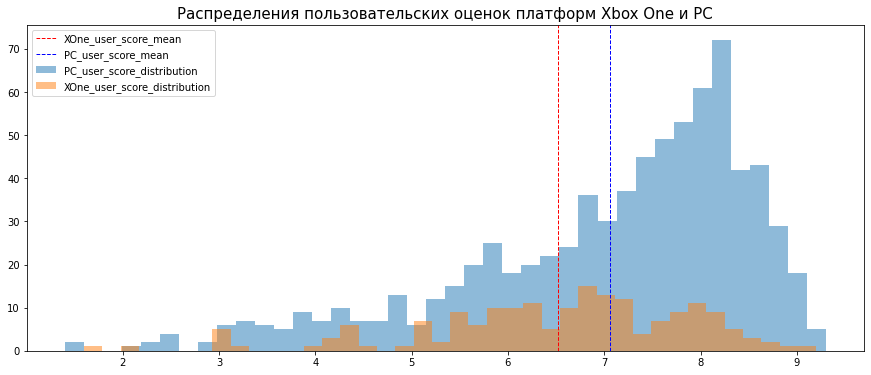

,XOne_summary
count,182.000000
mean,6.521429
std,1.380941
min,1.600000
25%,5.800000
50%,6.800000
75%,7.500000
max,9.200000


,PC_summary
count,770.000000
mean,7.062468
std,1.529963
min,1.400000
25%,6.200000
50%,7.500000
75%,8.200000
max,9.300000


In [35]:
# визуализация пользовательсикх рейтингов платформ Xbox One и PC
plt.figure(figsize=(15, 6))

plt.hist(df[df['platform'] == 'PC']['user_score'], 
         alpha=0.5, 
         bins=40, 
         label='PC_user_score_distribution')

plt.hist(df[df['platform'] == 'XOne']['user_score'], 
         alpha=0.5, 
         bins=40, 
         label='XOne_user_score_distribution')

plt.axvline(df[df['platform'] == 'XOne']['user_score'].mean(),
           color='r', 
            linestyle='dashed', 
            linewidth=1, 
            label='XOne_user_score_mean')

plt.axvline(df[df['platform'] == 'PC']['user_score'].mean(),
           color='b', 
            linestyle='dashed', 
            linewidth=1, 
            label='PC_user_score_mean')

plt.title('Распределения пользовательских оценок платформ Xbox One и PC', fontsize=15)
plt.legend()
plt.show()

# статистики распределений пользовательских оценок платформ Xbox One и PC
display(df[df['platform'] == 'XOne'][['user_score']]
        .describe()
        .rename({'user_score': 'XOne_summary'}, axis=1))

display(df[df['platform'] == 'PC'][['user_score']]
        .describe()
        .rename({'user_score': 'PC_summary'}, axis=1))

Итак, статистической проверки подлежат выборки пользовательских оценок игр, выпущенных на платформах Xbox One и PC.

Выборка пользовательских оценок для платформы РС представлена 770 наблюдениями, со средним значением в 7 и стандартным отклонением в 1,5.

Выборка пользовательских оценок для платформы XOne представлена 182 наблюдениями, со средним значением в 6,5 и стандартным отклонением в 1,4.

Оба распредления не имеют выбросов. Наблюдений достаточно. Будем исходить из предпосылки о независимости выборок, - игроки на РС и игроки на XOne - не связанные наблюдения. Даное предполжение сделаем исходя из того, что для разных платформ выходят разные игры в разное время и польщователи не имеют возможности поиграть в одну и туже игру в одно время, но на различных платформах. Таким образом, для проверки гипотезы представляется возможным использователь t-тест, с уловием неравенста дисперсий (тест Уэлча) - в виду различного характера платформ и выпускаемым для этих платформ игр, а также двусторонний характер проверки гипотезы - средние пользовательские оценки могут разниться, как в большую, так и в меньшую стороны. В виду достаточного количества наблюдений, допущение t-теста о необходимости нормального распределения средних величин будет также выполнено (согласно теореме Центрального предела).

Таким образом, нулевая гипотеза следующая (Н0): средние пользовательские рейтинги платформы Xbox One равны средним пользовательсикм рейтингам платформы PС.

Альтернатия гипотеза сформулирована следующим образом(Н1): средние пользовательские рейтинги платформы Xbox One не равны средним пользовательсикм рейтингам платформы PС.

Определим зону критической значимости в 0,05.

In [36]:
# двусторонний t-test для независимых выборок
print('p_value:', st.ttest_ind(df[df['platform'] == 'XOne']['user_score'].dropna(),
             df[df['platform'] == 'PC']['user_score'].dropna(), 
             equal_var=False, 
             alternative='two-sided').pvalue)

p_value: 4.935072360183565e-06


Итак, полученное в результате t-теста значение p-value меньше заявленного погорового значения alpha. Таким образом, есть основания отклонить H0. Таким образом, средние пользовательские рейтинги платформы Xbox One и PС статистически-значимо отличаются.

### Средние пользовательские рейтинги жанров Action и Sports разные

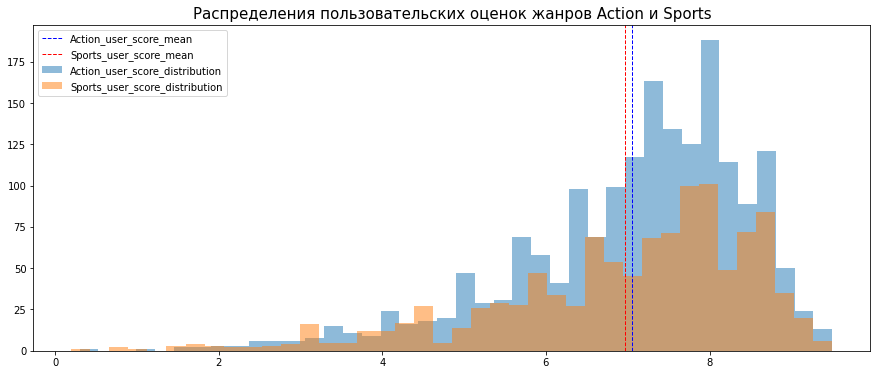

,Action_summary
count,1830.000000
mean,7.054044
std,1.425394
min,0.300000
25%,6.300000
50%,7.400000
75%,8.100000
max,9.500000


,Sports_summary
count,1103.000000
mean,6.961197
std,1.611370
min,0.200000
25%,6.100000
50%,7.400000
75%,8.100000
max,9.500000


In [37]:
# визуализация пользовательсикх рейтингов платформ Xbox One и PS
plt.figure(figsize=(15, 6))

plt.hist(df[df['genre'] == 'Action']['user_score'], 
         alpha=0.5, 
         bins=40, 
         label='Action_user_score_distribution')

plt.hist(df[df['genre'] == 'Sports']['user_score'], 
         alpha=0.5, 
         bins=40, 
         label='Sports_user_score_distribution')

plt.axvline(df[df['genre'] == 'Action']['user_score'].mean(),
            color='b', 
            linestyle='dashed', 
            linewidth=1, 
            label='Action_user_score_mean')

plt.axvline(df[df['genre'] == 'Sports']['user_score'].mean(),
            color='r', 
            linestyle='dashed', 
            linewidth=1, 
            label='Sports_user_score_mean')

plt.title('Распределения пользовательских оценок жанров Action и Sports', fontsize=15)
plt.legend()
plt.show()

# статистики распределений пользовательских оценок жанров Action и Sports
display(df[df['genre'] == 'Action'][['user_score']]
        .describe()
        .rename({'user_score': 'Action_summary'}, axis=1))

display(df[df['genre'] == 'Sports'][['user_score']]
        .describe()
        .rename({'user_score': 'Sports_summary'}, axis=1))

Выборка экшн-жанра представлена 1830 наблюдениями со средним значением в 7 и стандартным отклонением в 1,4. Выборка спортивных игр представлена 1103 наблюдениями со средним значением в 6,9 и стандартным отклонением в 1,6.

Для статистической проверки гипотез будем испольщовать t-тест, по идентичным с проверкой различий пользовательсикх оценок в разрезе платформ причинам.

Гипотезы:

Н0: средние пользовательские рейтинги жанра Action равны средним пользовательским рейтингам жанра Sports;

Н1: средние пользовательские рейтинги жанра Action не равны средним пользовательским рейтингам жанра Sports.

Пороговое значние критической зоны значимости:

alpha=0,05.

In [38]:
# двусторонний t-test для независимых выборок
print('p_value:', st.ttest_ind(df[df['genre'] == 'Action']['user_score'].dropna(),
             df[df['genre'] == 'Sports']['user_score'].dropna(), 
             equal_var=False, 
             alternative='two-sided').pvalue)

p_value: 0.11483818791498286


Расчетное p-value превышает определенное пороговое значение alpha. Таким образом, оснований отклонить нулевую гипотез нет. Таким образом, статетистически значимые различий между пользовательскими оценками игр жанров экшн и спортивных игр отсутствуют.

### Выводы по результатам проверки гипотез

Требовалось проверить статистическую значимость различий оценок игроков в разрезе платформ (XOne и PC), в разрезе жанров (Action и Sports).

Для проверки различий использовались среднии оценки и параметрический тест.

Так, пользовательские оценки игр в разрезе платформ XOne и PC статистически значимо различаются: игроки по разному оценивают игры выпущенные на платформах XOne и PC.

Пользовательские оценки жанров Action и Sports статисчески значимо не отличаются: игроки одинаково оценивают игры жанров Action и Sports.

## Выводы по результатам исследования

В ходе исследования требовалось выделить паттерны успешности продукта на примере компьтерных игр. Мерой успешности продукта автор работы посчитал объем продаж

Определяющие закономерности выявлялись аналитическим путем в динамике по годам, регионам продаж, игровым платформам, жанрам, оценкам пользователей и критиков, а также рейтинга ESRB. Составлены портреты пользователей по регионам продаж. Проверены гипотезы о различиях в пользовательсикх оценках игр в разрезе двух платформ и двух жанров.

Проведенным анализом установлено следующее:

1. Рост рынка видеоигр произошел в 1996 году с пиком в 2008 году и плавным спадом к 2016 году.
2. Лидером среди рынков сбыта за весь анализируемый период является Севеная Америка, аутсайдером - Япония.
3. Максимальные объемы продаж игр омечены на следующих платформах - DS, PS, PS2, PS3, Wii, X360, при этом платформа DS характерна для Японии, прочие выделенные платформы популярны во всех представленных регионах.
4. Исходя из объема реализации игр, выделены актуальные данные для дальнейшего анализа - горизонт анализа - 2014 год, игровые платформы: PS3, Wii, X360.
5. На примере платформы PS3 установлена прямая линейная зависимость объема продаж игр от оценок, как экспертов, так и игроков, при этом пик продаж игр наблюдается при скоре близком к 70-ти для критиков и оценке в  районе 6 для игроков. Вывод подтвержден на прочих платформах.
6. Жанр прямо влияет на объем продаж, так шутеры лучше всего продаются всех регионах, а стратегии исключительно в Японии.

Таким образом, по релультатам исследовательского анализа данных автором выделены следующие критерии успешности игры:

- регион распрастранения - Северная Америка,
- платформа - PS3,
- жанр - шутер,
- оценка в районе 70 от критиков и в районе 6 от игроков.

В ходе составления портрета игроков по регионам рассмотрены предпочтения пользоватлей в разрезе платформ, жанров и содерания игр.

Так, для северо-американский потребетилей определены следующие паттерны:

- предпочитают платформу X360;
- жанры спорт,шутеры и экшн;
- игры для взрослых.

Европейцы:

- отдают предпочтение платформам PS;
- жанрам спорт, экшн и шутеры;
- игры общей игровой аудитории.

Япония:

- платформа PS;
- жанр - экшн и спеифические файтинг и ролевые игры;
- игры вне рейтинга ESRB.

Результатами проверки гипотез стали следующие выводы:

Пользовательские оценки игр в разрезе платформ XOne и PC статистически значимо различаются: игроки по разному оценивают игры выпущенные на платформах XOne и PC.

Пользовательские оценки жанров Action и Sports статисчески значимо не отличаются: игроки одинаково оценивают игры жанров Action и Sports.

Проведенное исследование позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.